In [8]:
import polyfingerprints as pfp
import pandas as pd
import numpy as np
from wrapconfig import YAMLWrapConfig
import os
import shutil
import matplotlib.pyplot as plt
from polyfingerprints import models as pfp_models
import torch

In [9]:
BASEMODEL_DIR="models"
MODELNAME="test4"
INFERCSV="cloud_points_infer.csv"

In [47]:
modeldir=os.path.abspath(os.path.join(BASEMODEL_DIR,MODELNAME))
traininfofile = YAMLWrapConfig(os.path.join(modeldir,"expanded_info.yml"),default_save=False)
hyperparameter=YAMLWrapConfig(os.path.join(modeldir,("hyperparameter.yml")),default_save=False)

inferdf=pd.read_csv(INFERCSV)
if "cloud_point" in interdf.columns:
    interdf=inferdf.drop("cloud_point",axis=1)
inferdf

NameError: name 'interdf' is not defined

In [48]:
inferdf["pH"] = inferdf["pH"].fillna(7)
DEF_TYPE_MAP = {
        "A": 0.1,
        "B": 0.2,
        "C": 0.5,
        "DSC": 0.01,
    }
inferdf["def_type"] = inferdf["def_type"].fillna("0.1")
inferdf["def_type"] = inferdf["def_type"].apply(
    lambda x: float(
        (DEF_TYPE_MAP[x] if x in DEF_TYPE_MAP else str(x).replace(",", "."))
    ),
)

# set poly_conc to polymer_concentration_mass_conc where it is NaN
if "polymer_concentration_mass_conc" in inferdf.columns:
    inferdf["polymer_concentration_wpercent"] = inferdf["polymer_concentration_wpercent"].fillna(inferdf["polymer_concentration_mass_conc"])
    inferdf= inferdf.drop(
        ["polymer_concentration_mass_conc"], axis=1
    )

df,info = pfp.datareader.expand_data(
    inferdf,
    ignored_columns=[],
    density=1,
additive_wp_column_postfix = "_concentration_weight_percent",
    additive_conc_column_postfix="_concentration_molar"
    

)
additives_rename={}

for i,add in enumerate(info["additives"]):
    additives_rename[f"additive_{i}"]=f"additive_{traininfofile['additives'].index(add)}"

additives_missing=[f"additive_{i}" for i,add in enumerate(traininfofile["additives"]) if add not in info["additives"]]

df.rename(additives_rename,inplace=True,axis=1)
for madd in additives_missing:
    if madd in df.columns:
        raise ValueError("this should not happen")
    df[madd]=0

display(df)

additional_columns=traininfofile["numerical_columns"]+traininfofile["categorical_columns"]
if "cloud_point" in additional_columns:
    additional_columns.remove("cloud_point")

pfpdata = pfp.loader.df_loader(
        df=df,
        repeating_unit_columns=tuple(
            zip(
                info["repeating_unit_columns"],
                info["molpercent_repeating_unit_columns"],
            )
        ),
        mw_column="Mn",
        start_group_column="SMILES_start_group",
        end_group_column="SMILES_end_group",
        additional_columns= additional_columns,
        intersection_fp_size=hyperparameter["pfp_data"]["intersection_fp_size"],
        enhanced_sum_fp_size=hyperparameter["pfp_data"]["enhanced_sum_fp_size"]
    )

,SMILES_start_group,SMILES_end_group,SMILES_repeating_unitA,molpercent_repeating_unitA,SMILES_repeating_unitB,molpercent_repeating_unitB,SMILES_repeating_unitC,molpercent_repeating_unitC,SMILES_repeating_unitD,molpercent_repeating_unitD,...,additive_24,additive_25,additive_26,additive_27,additive_28,additive_29,additive_30,additive_31,additive_32,additive_33
0,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.200,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CC1),0.075,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CCC1),0.075,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CCCC1),0.075,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CCCCCC1),0.075,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
106,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
107,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
108,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Creating Polyfingerprints: 100%|██████████| 82/82 [00:01<00:00, 78.43it/s] 


In [49]:
reduction_data = dict(np.load(os.path.join(modeldir,("pfp_reduction.npz"))))
red_fp = pfp.apply_reduction_fp_set([pfpd["pfp"] for pfpd in pfpdata],reduction_data["mask"],reduction_data['reference_fp'])
for i,pfpd in enumerate(pfpdata):
    pfpd["pfp"]=red_fp[i]

2023-11-30 19:02:13,143 - polyfingerprints - INFO - mean reduction loss is 0% with the highest loss per fingerprint beeing 0%


0.0 0.0


In [50]:
hyperparameter=YAMLWrapConfig(os.path.join(modeldir,"hyperparameter.yml"),default_save=False)
modelclass=getattr(pfp_models,hyperparameter["model"]["model"])
modelpath=os.path.join(modeldir,"best_model.ckpt")
model = modelclass.load_from_checkpoint(modelpath,**hyperparameter["model"]["model_hp"])

In [51]:
x, y = pfp.loader.to_input_output_data(pfpdata)
yhat=model(torch.from_numpy(x).float()).detach().numpy()

In [53]:
inferdf.loc[df.index,"cloud_point"]=yhat
inferdf.to_csv(INFERCSV,index=False)
inferdf

,SMILES_start_group,SMILES_end_group,SMILES_repeating_unitA,molpercent_repeating_unitA,SMILES_repeating_unitB,molpercent_repeating_unitB,SMILES_repeating_unitC,molpercent_repeating_unitC,SMILES_repeating_unitD,molpercent_repeating_unitD,...,polymer_concentration_wpercent,additive1,additive1_concentration_molar,additive1_concentration_weight_percent,additive2,additive2_concentration_molar,additive2_concentration_weight_percent,def_type,pH,cloud_point
0,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.200,NaN,NaN,NaN,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.1,7.0,38.391224
1,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CC1),0.075,NaN,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.1,7.0,45.738602
2,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CCC1),0.075,NaN,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.1,7.0,38.864311
3,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CCCC1),0.075,NaN,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.1,7.0,46.764484
4,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),0.8,[CH2][CH](C(=O)O),0.125,[CH2][CH](C(=O)NC1CCCCCC1),0.075,NaN,NaN,...,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.1,7.0,40.756573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.01,[Rb+].[Cl-],1.0,NaN,NaN,NaN,NaN,0.1,7.0,19.162506
106,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.01,[Rb+].[Cl-],2.0,NaN,NaN,NaN,NaN,0.1,7.0,9.180828
107,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.01,[Na+].[Cl-],1.0,NaN,NaN,NaN,NaN,0.1,7.0,20.233894
108,[C](C)(C)(C#N),[C](C)(C)C#N,[CH2][CH](C(=O)NC(C)C),1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.01,[Na+].[Cl-],2.0,NaN,NaN,NaN,NaN,0.1,7.0,12.263154


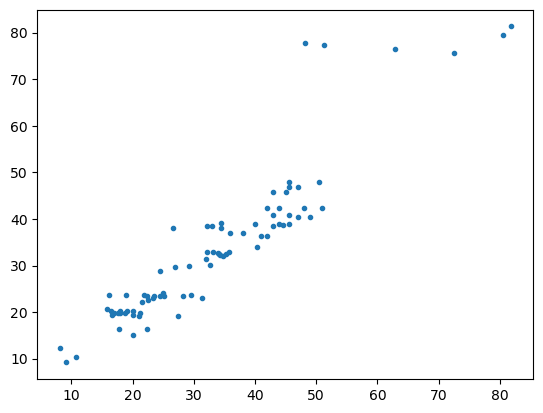

In [66]:
plt.plot(raw_df.iloc[:110]["cloud_point"].values,inferdf["cloud_point"].values,".")

In [72]:
np.sqrt(np.nanmean(((raw_df.iloc[:110]["cloud_point"].values-inferdf["cloud_point"].values)**2)))

6.03910040507808